### **Fontes de pesquisa:**
> **Artigos** 
- 4 Strategies for Multi-Step Time Series Forecasting: https://machinelearningmastery.com/multi-step-time-series-forecasting/
- How to Convert a Time Series to a Supervised Learning Problem in Python: https://machinelearningmastery.com/convert-time-series-supervised-learning-problem-python/
- Time Series Forecasting as Supervised Learning: https://machinelearningmastery.com/time-series-forecasting-supervised-learning/
- How to Use XGBoost for Time Series Forecasting: https://machinelearningmastery.com/xgboost-for-time-series-forecasting/

> **Documentação**
- Métricas de Avaliação: https://scikit-learn.org/stable/modules/model_evaluation.html

In [1]:
# Data processing
import pandas as pd
import numpy as np
import seaborn as sns

# Standardize the data (padronização)
from sklearn.preprocessing import StandardScaler

# Modeling 
from sklearn.svm import SVR

from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, mean_absolute_error
from matplotlib import pyplot as plt


import warnings
warnings.filterwarnings("ignore")
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [4]:
svr = SVR()
svr.fit()


TypeError: fit() missing 2 required positional arguments: 'X' and 'y'

In [2]:
# vamos importar a base de produção de energia elétrica
df = pd.read_csv('https://raw.githubusercontent.com/luk3mn/TCC-predicao-de-series-temporais/master/dataset/pld_norte.csv', index_col='inicio_semana', parse_dates=True)
# df = pd.read_csv('C:\projetos\jupyter_notebook\hyperparams_optimization\_data\pld_norte.csv', index_col='inicio_semana', parse_dates=True)

# Removendo todos as virgulas do dataset
df.replace(',','.', regex=True, inplace=True)

# Convertendo todos os objetos para valores numericos
c = df.select_dtypes(object).columns
df[c] = df[c].apply(pd.to_numeric,errors='coerce')
df.head()

,preco_pesado,preco_medio,preco_leve,geracao_hidraulica,geracao_termica,carga_energia,reservatorio_EARM,reservatorio_ENA
inicio_semana,,,,,,,,
2001-08-04,684.0,684.0,684.0,2952.29,0.0,2204.00,62.42,89.57
2001-08-11,684.0,684.0,684.0,2956.57,0.0,2141.57,59.75,88.57
2001-08-18,684.0,684.0,684.0,2909.71,0.0,2110.43,56.75,83.86
2001-08-25,684.0,684.0,684.0,2631.00,0.0,2095.43,53.63,79.29
2001-09-01,684.0,684.0,684.0,2558.86,0.0,2069.14,50.64,76.00


In [3]:
df = df.drop(columns=['preco_pesado','preco_leve','geracao_hidraulica','geracao_termica','carga_energia','reservatorio_EARM','reservatorio_ENA'])
# df = df[23:len(df)-22]
df

,preco_medio
inicio_semana,
2001-08-04,684.00
2001-08-11,684.00
2001-08-18,684.00
2001-08-25,684.00
2001-09-01,684.00
...,...
2009-11-28,16.31
2009-12-05,16.31
2009-12-12,16.31


<AxesSubplot: xlabel='inicio_semana'>

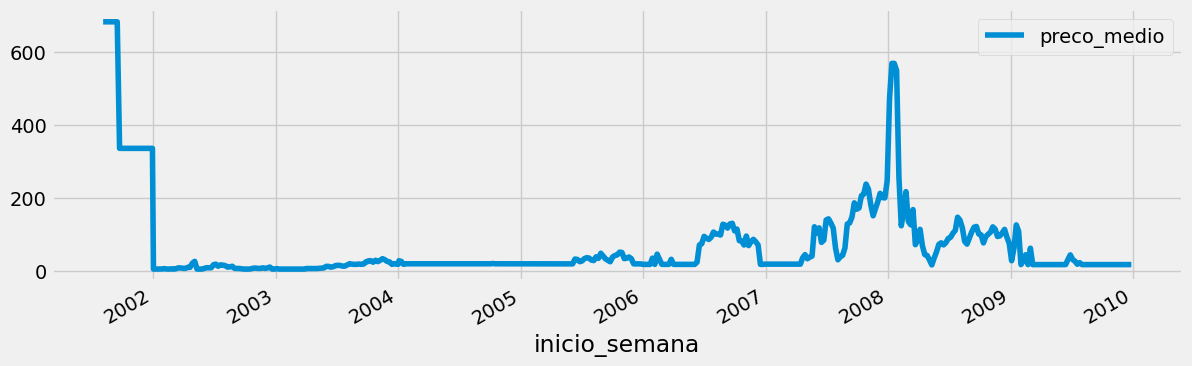

In [4]:
df.plot(figsize=(13,4))

## Pré-processamento
> Separação dos dados em treino / teste

In [5]:
def split_dataset(data, set_size, show_series):
    x = data
    size = int(len(x) * set_size)
    train, test = x[0:size], x[size:len(x)]
    if show_series:
        print("\nBASE DE TREINO\n",train.tail())
        print("\nBASE DE TESTE\n",test.head())
    else:
        print("BASE DE TREINO: ",len(train))
        print("BASE DE TESTE:  ",len(test))
    return train, test

In [6]:
train_set, test_set = split_dataset(df, 0.75, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2007-10-06          172.08
2007-10-13          205.54
2007-10-20          209.96
2007-10-27          237.66
2007-11-03          223.89

BASE DE TESTE
                preco_medio
inicio_semana             
2007-11-10          181.30
2007-11-17          150.54
2007-11-24          169.65
2007-12-01          189.25
2007-12-08          212.20


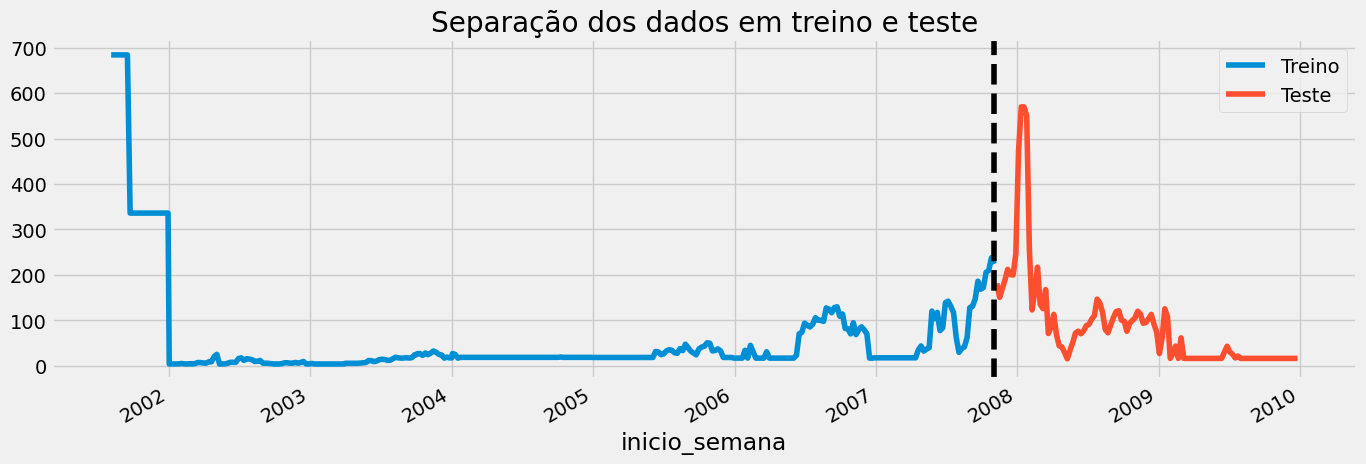

In [7]:
fig, ax = plt.subplots(figsize=(15, 5))
train_set.plot(ax=ax, label='Treino', title='Separação dos dados em treino e teste')
test_set.plot(ax=ax, label='Teste')
ax.axvline('2007-11-03', color='black', ls='--')
ax.legend(['Treino', 'Teste'])
plt.show()

> Feature Engineering

In [8]:
# from pandas import DataFrame
# from pandas import concat

# def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
# 	"""
# 	Frame a time series as a supervised learning dataset.
# 	Arguments:
# 		data: Sequence of observations as a list or NumPy array.
# 		n_in: Number of lag observations as input (X).
# 		n_out: Number of observations as output (y).
# 		dropnan: Boolean whether or not to drop rows with NaN values.
# 	Returns:
# 		Pandas DataFrame of series framed for supervised learning.
# 	"""
# 	n_vars = 1 if type(data) is list else data.shape[1]
# 	df = DataFrame(data)
# 	cols, names = list(), list()
# 	# input sequence (t-n, ... t-1)
# 	for i in range(n_in, 0, -1):
# 		cols.append(df.shift(i))
# 		names += [('X%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# 	# forecast sequence (t, t+1, ... t+n)
# 	for i in range(0, n_out):
# 		cols.append(df.shift(-i))
# 		if i == 0:
# 			names += [('y%d(t)' % (j+1)) for j in range(n_vars)]
# 		else:
# 			names += [('y%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# 	# put it all together
# 	agg = concat(cols, axis=1)
# 	agg.columns = names
# 	# drop rows with NaN values
# 	if dropnan:
# 		agg.dropna(inplace=True)
# 	return agg

# tam_janela = 1
# passos = 2
# train_data_features = series_to_supervised(train_set, n_in=tam_janela, n_out=passos)
# test_data_features = series_to_supervised(test_set, n_in=tam_janela, n_out=passos)

In [8]:
def series_to_supervised_lag(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['t-'+str(i)] = serie.shift(i)
    features = features.iloc[steps_in:] # remove linhas iniciais com nan
    return features

def series_to_supervised(serie, steps_in):
    features = pd.DataFrame() # dataframe para retorno
    features['t'] = serie # valores em t
    for i in range(1, steps_in+1): # valores em t-1, t-2, .. t-steps_in
        features['target+'+str(i)] = serie.shift(-i)
    features = features.dropna() # remove linhas iniciais com nan
    return features

In [9]:
passos = 3
train_data_features = series_to_supervised(serie=train_set, steps_in=passos)
test_data_features = series_to_supervised(serie=test_set, steps_in=passos)

print(train_data_features.tail())
print(test_data_features.head())

                    t  target+1  target+2  target+3
inicio_semana                                      
2007-09-15     147.26    186.16    168.46    172.08
2007-09-22     186.16    168.46    172.08    205.54
2007-09-29     168.46    172.08    205.54    209.96
2007-10-06     172.08    205.54    209.96    237.66
2007-10-13     205.54    209.96    237.66    223.89
                    t  target+1  target+2  target+3
inicio_semana                                      
2007-11-10     181.30    150.54    169.65    189.25
2007-11-17     150.54    169.65    189.25    212.20
2007-11-24     169.65    189.25    212.20    200.48
2007-12-01     189.25    212.20    200.48    199.76
2007-12-08     212.20    200.48    199.76    247.01


In [10]:
X_train = train_data_features.drop(columns=['target+'+str(passos)]).values
y_train = train_data_features.iloc[:,[passos]].values
X_test = test_data_features.drop(columns=['target+'+str(passos)]).values
y_test = test_data_features.iloc[:,[passos]].values

In [11]:
print('X Test: ', X_test[0])
print('y Test: ', y_test[0])

X Test:  [181.3  150.54 169.65]
y Test:  [189.25]


In [12]:
svr = SVR(C=6.95, epsilon=0.048) # 0.7412 (arredondado)
svr.fit(X_train, y_train)

# Verifica a acurácia
# print(f'O ponto de acurácia do modelo é {svr.score(X_test, y_test):.4f}')

SVR(C=6.95, epsilon=0.048)

In [114]:
i = 0
print("ITERAÇÃO ", i)
print("X Teste: ", X_test.reshape(1, -1))
print("y Teste: ", y_test.reshape(1, -1))

print("\nX Predicao: ", X_test[i])
_1passos = svr.predict([X_test[i]])
print("y Real: ", y_test[i])
print("Predito: ", _1passos)

ITERAÇÃO  0
X Teste:  [[256.05 550.28 569.59 ...  16.31  16.31  16.31]]
y Teste:  [[122.93 163.45 216.94 135.19 125.78 167.6   71.08  85.23 113.25  68.18
   43.94  41.33  29.32  15.47  34.29  51.11  71.85  76.16  70.51  76.72
   88.11  91.32 102.58 110.23 146.66 138.64 117.87  80.13  72.65 105.83
  119.06 121.19 100.39  98.1   75.98  93.23  99.75 105.39 120.12 113.75
   93.6   95.35 103.56 113.15  91.74  74.1   26.95  61.21 125.44 107.59
   16.31  27.06  43.44  16.31  61.47  16.31  16.31  16.31  16.31  16.31
   16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31
   30.17  43.08  30.4   25.45  17.32  21.5   16.31  16.31  16.31  16.31
   16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31
   16.31  16.31  16.31  16.31  16.31  16.31  16.31  16.31]]

X Predicao:  [256.05 550.28 569.59 569.59 473.3  247.01 199.76 200.48 212.2  189.25
 169.65 150.54 181.3 ]


NotFittedError: This SVR instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.

> Otimização por busca randomica

In [9]:
# Check default values
svr = SVR()

# List of C values
# C_range = np.logspace(-2, 2, 10)
C_range = np.logspace(-1, 2, 10000)
print(f'\nThe list of values for C are {C_range}')

# List of gamma values
gamma_range = np.logspace(-6, -5, 19)
print(f'\nThe list of values for gamma are {gamma_range}')

# List of epsilon values
# epsilon_range = np.logspace(-1, 2, 100)
epsilon_range = np.logspace(-1, 0, 10000)
print(f'\nThe list of values for epsilon are {epsilon_range}')


The list of values for C are [  0.1          0.10006911   0.10013826 ...  99.86192649  99.9309394
 100.        ]

The list of values for gamma are [1.00000000e-06 1.13646367e-06 1.29154967e-06 1.46779927e-06
 1.66810054e-06 1.89573565e-06 2.15443469e-06 2.44843675e-06
 2.78255940e-06 3.16227766e-06 3.59381366e-06 4.08423865e-06
 4.64158883e-06 5.27499706e-06 5.99484250e-06 6.81292069e-06
 7.74263683e-06 8.79922544e-06 1.00000000e-05]

The list of values for epsilon are [0.1        0.10002303 0.10004607 ... 0.99953954 0.99976974 1.        ]


In [10]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import RandomizedSearchCV, cross_val_score

# Define the search space
param_grid = { 
    # Regularization parameter.
    "C": C_range,
    "epsilon": epsilon_range,
    # Kernel type
    # "kernel": ['rbf', 'poly',],
    # Gamma is the Kernel coefficient for ‘rbf’, ‘poly’ and ‘sigmoid’.
    "gamma": gamma_range.tolist()+['scale', 'auto']
}

# Set up score
scoring = ['neg_mean_squared_error']
ts_cv = TimeSeriesSplit(n_splits=5)

# Define random search
random_search = RandomizedSearchCV(estimator=svr, 
                           param_distributions=param_grid, 
                           n_iter=100,
                           scoring=scoring, 
                           refit='neg_mean_squared_error', 
                           n_jobs=-1, 
                           cv=ts_cv, 
                           verbose=0)

## Previsão em Etapas de Tempo

In [14]:
def fit_predict_steps(passos=1, otimizacao=False, C=1.0, epsilon=0.1, gamma=1.0):
    predicted = []
    yTrue = []
    mae_error = []
    mse_error = []

    for i in range(1, passos+1):
        train_data_features = series_to_supervised(serie=train_set, steps_in=i)
        test_data_features = series_to_supervised(serie=test_set, steps_in=i)

        X_train = train_data_features.drop(columns=['target+'+str(i)]).values
        y_train = train_data_features.iloc[:,[i]].values
        X_test = test_data_features.drop(columns=['target+'+str(i)]).values
        y_test = test_data_features.iloc[:,[i]].values

        # treina o modelo
        if otimizacao:
            opt = random_search
            opt.fit(X_train, y_train)
            C, epsilon, gamma = [opt.best_estimator_.C, opt.best_estimator_.epsilon, opt.best_estimator_.gamma]
        svr = SVR(C=C, epsilon=epsilon, gamma=gamma)
        svr.fit(X_train, y_train)

        pred = svr.predict([X_test[0]])
        true = y_test[0]
        mae = mean_absolute_error(pred, true)
        mse = mean_squared_error(pred, true)

        print('[{}] Real: {} || Predito: {} || MAE: {} => SVR(C={}, epsilon={}, gamma={})'.format(i, true, pred, mae, C, epsilon, gamma))

        predicted.append(pred)
        yTrue.append(true)
        mae_error.append(mae)
        mse_error.append(mse)

    return predicted, yTrue, mae_error, mse_error

In [18]:
def plot_result(predictions, y_true, mae=0, mse=0, rmse=0, title='', xlabel=''):
    fig = plt.subplots(figsize=(8,4))
    plt.plot(y_true, label='Real')
    plt.plot(predictions, label='Previsto')
    if (mae != 0) | (mse != 0) | (rmse != 0):
        plt.title(f'{title}\nMSE: {mse:.3f} || RMSE: {rmse:.3f} || MAE: {mae:.3f}')
    else:
        plt.title(f'{title}')
    plt.xlabel('Periodo Observado')
    plt.ylabel(xlabel)
    plt.legend()
    plt.tight_layout()

In [22]:
pred_steps, y_true_steps, mae_steps, mse_steps = fit_predict_steps(passos=12, otimizacao=True)

[1] Real: [150.54] || Predito: [177.38591789] || MAE: 26.845917892997676 => SVR(C=91.09529563125787, epsilon=0.22570197196339203, gamma=1e-06)
[2] Real: [169.65] || Predito: [160.93967075] || MAE: 8.710329249267119 => SVR(C=99.03747970956547, epsilon=0.9111627561154894, gamma=6.8129206905796085e-06)
[3] Real: [189.25] || Predito: [172.76751997] || MAE: 16.482480026395194 => SVR(C=92.81042462954986, epsilon=0.7723048797037534, gamma=3.5938136638046257e-06)
[4] Real: [212.2] || Predito: [185.46608649] || MAE: 26.73391351401864 => SVR(C=90.53065854667376, epsilon=0.384024060941604, gamma=4.641588833612782e-06)
[5] Real: [200.48] || Predito: [200.99978339] || MAE: 0.51978338826288 => SVR(C=58.74581018442158, epsilon=0.12305776154924146, gamma=8.799225435691075e-06)
[6] Real: [199.76] || Predito: [200.20081979] || MAE: 0.4408197896939896 => SVR(C=77.12385312240156, epsilon=0.9471039322832021, gamma=5.994842503189409e-06)
[7] Real: [247.01] || Predito: [196.24153454] || MAE: 50.7684654558672

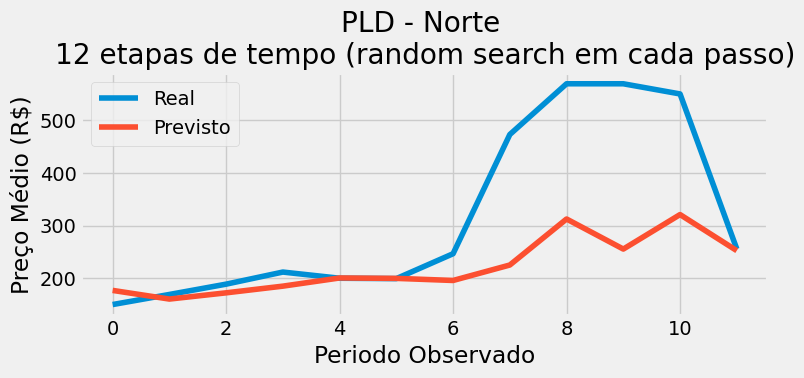

In [23]:
plot_result(predictions=pred_steps, y_true=y_true_steps, title='PLD - Norte \n12 etapas de tempo (random search em cada passo)', xlabel='Preço Médio (R$)')

In [24]:
pred, y_true, mae, mse = fit_predict_steps(passos=12, otimizacao=False, C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)

[1] Real: [150.54] || Predito: [179.94265089] || MAE: 29.402650888104574 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[2] Real: [169.65] || Predito: [162.75861197] || MAE: 6.891388031887033 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[3] Real: [189.25] || Predito: [173.03371838] || MAE: 16.216281621630287 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[4] Real: [212.2] || Predito: [185.78792254] || MAE: 26.412077461499507 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[5] Real: [200.48] || Predito: [202.68299672] || MAE: 2.2029967186698514 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[6] Real: [199.76] || Predito: [200.37893705] || MAE: 0.6189370509334822 => SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06)
[7] Real: [247.01] || Predito: [194.76883499] ||

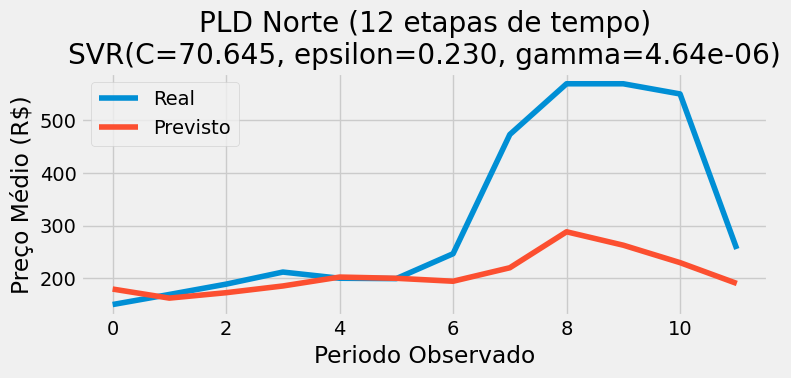

In [25]:
plot_result(predictions=pred, y_true=y_true, title='PLD Norte (12 etapas de tempo)\nSVR(C=70.645, epsilon=0.230, gamma=4.64e-06)', xlabel='Preço Médio (R$)')

> comparando os resultados

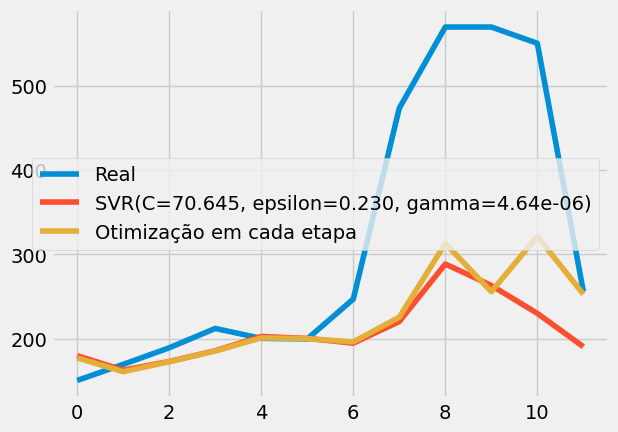

In [26]:
plt.plot(y_true, label='Real')
plt.plot(pred, label='SVR(C=70.645, epsilon=0.230, gamma=4.64e-06)')
plt.plot(pred_steps, label='Otimização em cada etapa')
plt.legend()

In [27]:
passos = []
for i in range(1,13):
    passos.append(i)

dataset_result = pd.DataFrame()
dataset_result['Passos'] = passos
dataset_result['Real'] = y_true
dataset_result['SVR(C, epsilon, gamma)'] = pred
dataset_result['MSE 1'] = mse
dataset_result['MAE 1'] = mae
dataset_result['BayeSearch por etapa'] = pred_steps
dataset_result['MSE 2'] = mse_steps
dataset_result['MAE 2'] = mae_steps
dataset_result

,Passos,Real,"SVR(C, epsilon, gamma)",MSE 1,MAE 1,BayeSearch por etapa,MSE 2,MAE 2
0,1,[150.54],[179.94265088810457],864.515879,29.402651,[177.38591789299767],720.703308,26.845918
1,2,[169.65],[162.75861196811297],47.491229,6.891388,[160.9396707507329],75.869836,8.710329
2,3,[189.25],[173.0337183783697],262.967790,16.216282,[172.7675199736048],271.672148,16.482480
3,4,[212.2],[185.78792253850048],697.597836,26.412077,[185.46608648598135],714.702132,26.733914
4,5,[200.48],[202.68299671866984],4.853195,2.202997,[200.99978338826287],0.270175,0.519783
5,6,[199.76],[200.37893705093347],0.383083,0.618937,[200.20081978969398],0.194322,0.440820
6,7,[247.01],[194.76883498875225],2729.139322,52.241165,[196.24153454413278],2577.437085,50.768465
7,8,[473.3],[220.37494996469522],63971.080935,252.925050,[225.5737356865887],61368.302031,247.726264
8,9,[569.59],[288.61193787182003],78948.671397,280.978062,[312.9234946972395],65877.694944,256.666505
9,10,[569.59],[263.1711567999547],93892.507468,306.418843,[255.82792066955614],98446.642426,313.762079


In [10]:
real = [150.54]
pred = [179.94]
print(mean_absolute_error(real, pred))
print(mean_absolute_error([150.54], [179.94265088810457]))
print(mean_absolute_error([150.5400000000], [179.94265088810457]))
print(mean_squared_error([150.54], [179.94265088810457]))
print(np.sqrt(mean_squared_error([150.54], [179.94265088810457])))
# print(round(179.94265088810457, 2))

29.400000000000006
29.402650888104574
29.402650888104574
864.5158792477567
29.402650888104574


## Previsão Direta

> Separação Treino e Teste

In [22]:
train, test = split_dataset(df, 0.75, True)


BASE DE TREINO
                preco_medio
inicio_semana             
2007-10-06          172.08
2007-10-13          205.54
2007-10-20          209.96
2007-10-27          237.66
2007-11-03          223.89

BASE DE TESTE
                preco_medio
inicio_semana             
2007-11-10          181.30
2007-11-17          150.54
2007-11-24          169.65
2007-12-01          189.25
2007-12-08          212.20


> Feature Engineering

In [23]:
steps_in = 13
train_data_features = series_to_supervised_lag(train, steps_in)
test_data_features = series_to_supervised_lag(test, steps_in)

In [24]:
X_train = train_data_features.drop(columns=['t']).values
y_train = train_data_features['t'].values
X_test = test_data_features.drop(columns=['t']).values
y_test = test_data_features['t'].values

> Busca Randomica

In [138]:
# opt = random_search(C_min=1e-2, C_max=1000.0)


# treina o modelo
# Fit grid search
random_result = random_search.fit(X_train, y_train)
C, epsilon, kernel, gamma = [random_result.best_estimator_.C, 
                             random_result.best_estimator_.epsilon, 
                             random_result.best_estimator_.kernel,
                             random_result.best_estimator_.gamma]
print(random_result.best_estimator_)
print(random_result.best_params_)
print(random_result.best_score_)
print(f'SVR(C={C}, epsilon={epsilon}, gamma={gamma})')

SVR(C=92.29889881639681, epsilon=0.3296490322927805,
    gamma=5.994842503189409e-06)
{'gamma': 5.994842503189409e-06, 'epsilon': 0.3296490322927805, 'C': 92.29889881639681}
-329.2132294245922
SVR(C=92.29889881639681, epsilon=0.3296490322927805, gamma=5.994842503189409e-06)


In [187]:
svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
# svr = SVR(C=10.0) # 0.4245427616665576
# svr = SVR(C=100.0, epsilon=1.0) # 0.7214366810286058
# svr = SVR(C=278.2559402207126, epsilon=3.1622776601683795) # 0.7065430498008374
# svr = SVR(C=100.0, epsilon=0.5623413251903491) # 0.7225254886071677
# svr = SVR(C=100.0, epsilon=0.8111308307896873) # 0.7213368801506537
# svr = SVR(C=100.0, epsilon=4.641588833612779, gamma=scale) # 0.7183168658417145 -> 'Gamma' ativado
# svr = SVR(C=4.6415888336127775, epsilon=28.48035868435802, gamma=scale) # 0.3905592645623984 -> 'Gamma' ativado com variação de 100 teste => logspace(-2, 2, 100)
# svr = SVR(C=100.0, epsilon=1.9737643263002553) # 0.7216258245847439 -> 'Gamma' desativado
# svr = SVR(C=100.0, epsilon=0.7846743728309852) # 0.7213715151621172 -> variação de 'epsilon' de 0 a 1 com 10000 testes
# svr = SVR(C=97.27203192450537, epsilon=0.30237651324560777) # 0.7230999313557853 -> variação de 'C' de 0 a 100 com 1000 testes
# svr = SVR(C=89.10354636170874, epsilon=0.11730240887216133) # 0.722471239755358 -> variação de 'C' de 0 a 100 com 10000 testes
# svr = SVR(C=93.06724964578, epsilon=0.4689938164586274) # 0.7237540847675984

# ===============================================================================================================================
# 'Gamma' Ativado com varição de 1e-06 a 100 com 10 testes, 'C' de 0 a 100 com 10000 testes e 'epsilon' de 0 a 1 com 10000 testes
#================================================================================================================================
# svr = SVR(C=76.64581540072594, epsilon=0.11896180381318075, gamma=7.742636826811277e-06) # 0.7345732549009698
# svr = SVR(C=98.1520082413826, epsilon=0.15603402873014716, gamma=7.742636826811277e-06) # 0.7435215886961859

# ===============================================================================================================================
# 'Gamma' Ativado com varição de 1e-08 a 100 com 10 testes, 'C' de 0 a 100 com 10000 testes e 'epsilon' de 0 a 1 com 10000 testes
# ===============================================================================================================================
# svr = SVR(C=37.80574109020105, epsilon=0.8786064343555854, gamma=1.6681005372000591e-06) # 0.7438043539110251

# ================================================================================================================================
# 'Gamma' Ativado com varição de 1e-10 a 1e-4 com 10 testes, 'C' de 0 a 100 com 10000 testes e 'epsilon' de 0 a 1 com 10000 testes
# ================================================================================================================================
# svr = SVR(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06) # 0.7501248062850344

# ================================================================================================================================
# 'Gamma' Ativado com varição de 1e-6 a 1e-5 com 15 testes, 'C' de 0 a 100 com 10000 testes e 'epsilon' de 0 a 1 com 10000 testes
# ================================================================================================================================
# svr = SVR(C=95.93966547436315, epsilon=0.8146875867813423, gamma=4.641588833612782e-06) # 0.7556090136260883
# svr = SVR(C=97.88115150922864, epsilon=0.6130257931048742, gamma=6.105402296585327e-06) # 0.7547097731447269


####################################################
# PARÂMETROS AJUSTADO A PARTIR DO MELHOR RESULTADO #
####################################################
svr = SVR(C=100, epsilon=3.1, gamma=5e-06) # 0.7614077456570736
svr.fit(X_train, y_train)
print(svr.score(X_test, y_test))

0.7616326182813782


> Previsão com lag Feature

In [53]:
def predict_svr(kernel='rbf', C=1.0, epsilon=0.1, gamma='scale', lag=1):

    # Criação dos Lags
    steps_in = lag
    train_data_features = series_to_supervised_lag(train, steps_in)
    test_data_features = series_to_supervised_lag(test, steps_in)

    # Definição de X e y
    X_train = train_data_features.drop(columns=['t']).values
    y_train = train_data_features['t'].values.reshape(-1, 1)
    X_test = test_data_features.drop(columns=['t']).values
    y_test = test_data_features['t'].values.reshape(-1, 1)

    # treina o modelo
    svr = SVR(kernel=kernel, C=C, epsilon=epsilon, gamma=gamma)
    svr.fit(X_train, y_train)
    predictions = svr.predict(X_test)
        
    # calculo do erro
    mae = mean_absolute_error(y_test, predictions)
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    mse = mean_squared_error(y_test, predictions)

    fig = plt.subplots(figsize=(8,4))
    plt.plot(y_test, label='Real')
    plt.plot(predictions, label='Previsto')
    plt.title('PLD (Norte) - {} lags\nMSE: {:.3f} || RMSE: {:.3f} || MAE: {:.3f}'.format(steps_in, mse, rmse, mae))
    plt.xlabel('Periodo Observado')
    plt.ylabel('Preço Médio (R$)')
    plt.legend()
    plt.tight_layout()

    return predictions, y_test

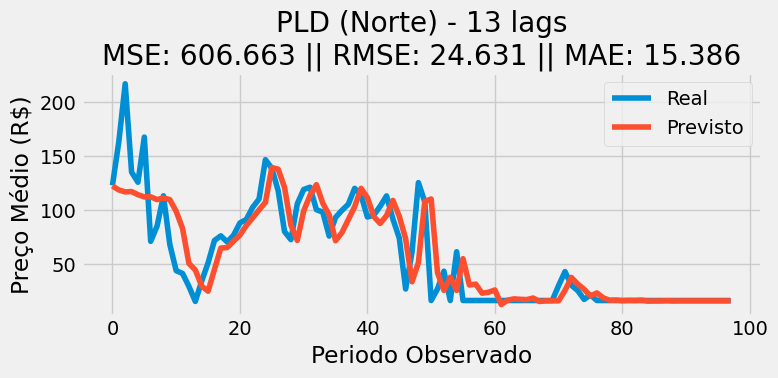

In [30]:
pred, ytrue = predict_svr(C=C, epsilon=epsilon, gamma=gamma, lag=13)

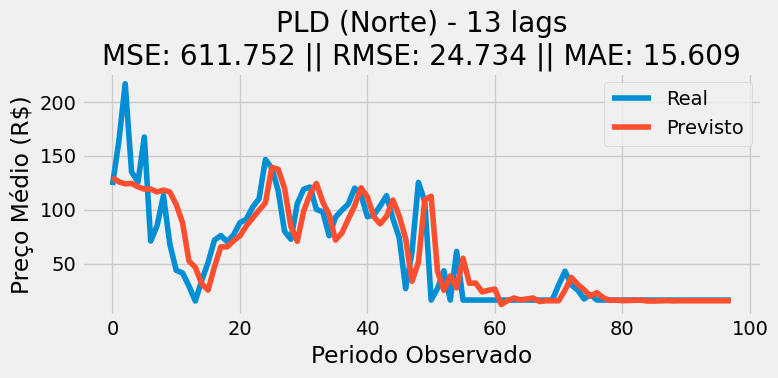

In [46]:
pred, ytrue = predict_svr(C=100.0, epsilon=1.0, lag=13)

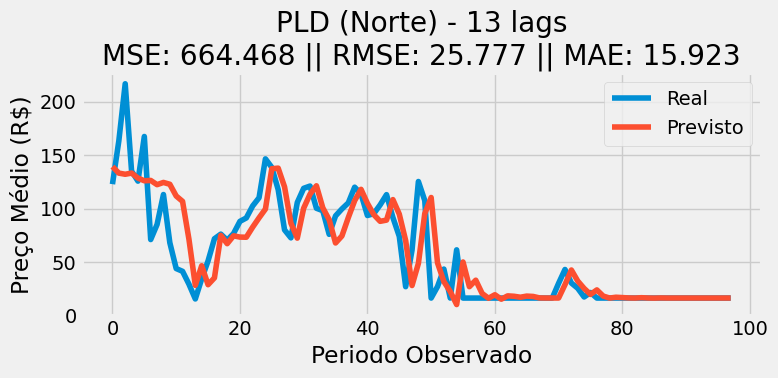

In [47]:
pred, ytrue = predict_svr(C=1000.0, epsilon=0.1, lag=13)

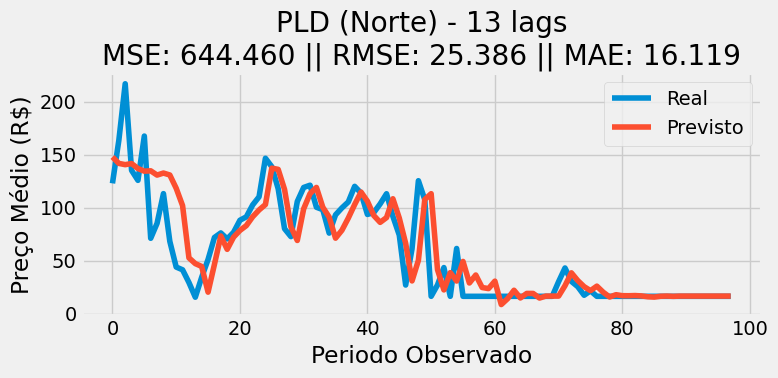

In [48]:
pred, ytrue = predict_svr(C=278.2559402207126, epsilon=3.1622776601683795, lag=13)

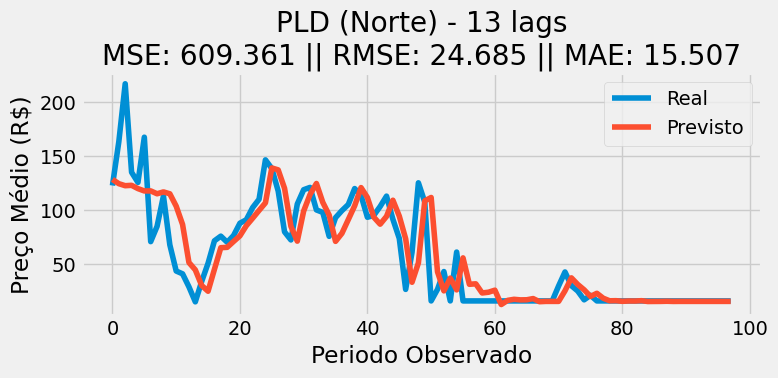

In [49]:
pred, ytrue = predict_svr(C=100.0, epsilon=0.5623413251903491, lag=13)

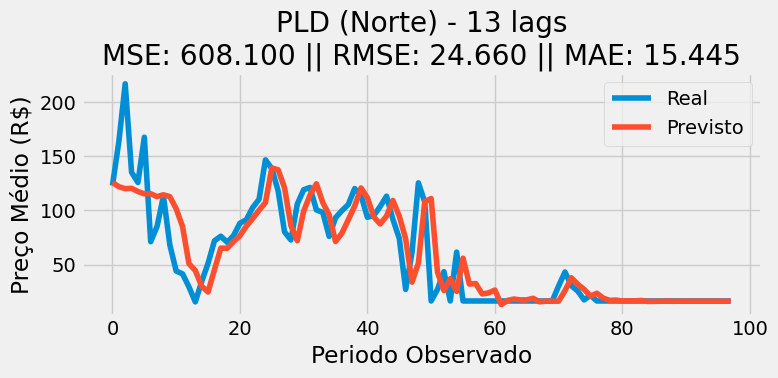

In [50]:
pred, ytrue = predict_svr(C=97.27203192450537, epsilon=0.30237651324560777, lag=13)

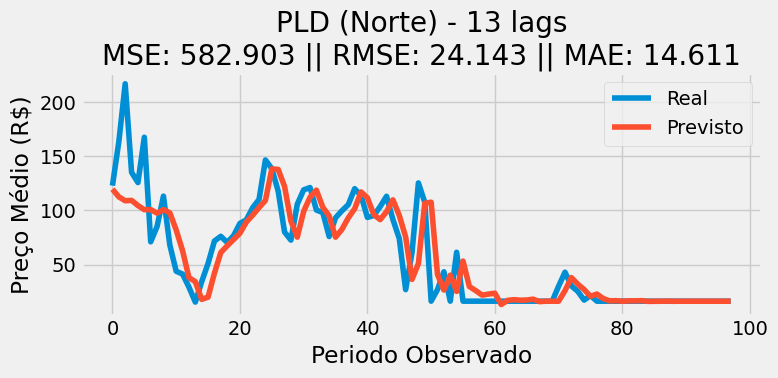

In [54]:
pred, ytrue = predict_svr(C=76.64581540072594, epsilon=0.11896180381318075, gamma=7.742636826811277e-06, lag=13)

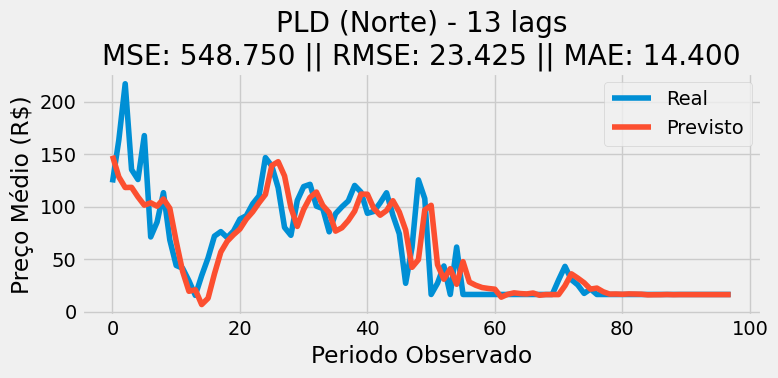

In [87]:
pred, ytrue = predict_svr(C=70.64556592194896, epsilon=0.23058777760916727, gamma=4.641588833612773e-06, lag=13)

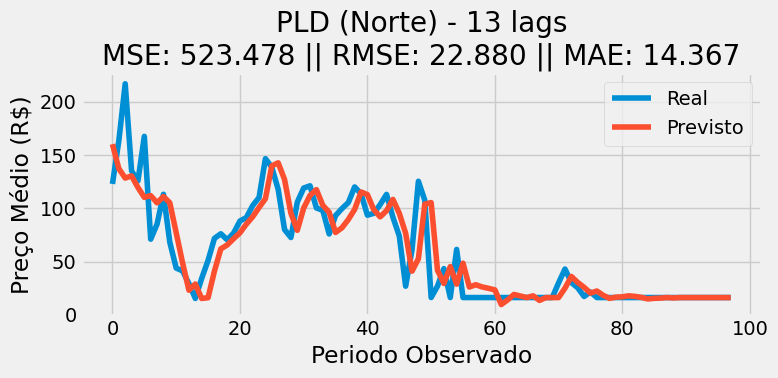

In [188]:
pred, ytrue = predict_svr(C=100, epsilon=3.1, gamma=5e-06, lag=13)

## Analisando os resultados

In [189]:
# svr = SVR(C=6.95, epsilon=0.048) # 0.7412 (arredondado)
# svr = SVR(C=5.2713416686699786, epsilon=0.0001)
svr = SVR(C=C, epsilon=epsilon, gamma=gamma)

# treinando o modelo
svr.fit(X_train, y_train)

# Verifica a acurácia
score = svr.score(X_test, y_test)
print(f'O ponto de acurácia do modelo é {score:.4f}')

O ponto de acurácia do modelo é 0.7546


In [190]:
# calculo do erro
mae = mean_absolute_error(ytrue, pred)
rmse = np.sqrt(mean_squared_error(ytrue, pred))
mse = mean_squared_error(ytrue, pred)

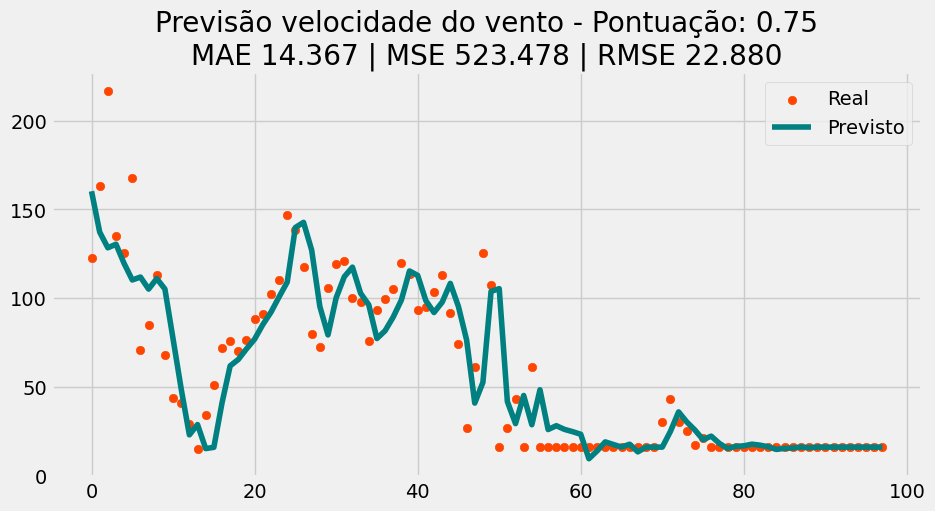

In [192]:
index = []
for i in range(len(ytrue)):
    index.append(i)

fig = plt.subplots(figsize=(10, 5))
plt.scatter(index, ytrue, label='Real', color='orangered')
plt.plot(pred, label='Previsto', color='teal')
plt.title(f'Previsão velocidade do vento - Pontuação: {score:.2f}\nMAE {mae:.3f} | MSE {mse:.3f} | RMSE {rmse:.3f}')
plt.legend()